In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle competitions download tensorflow2-question-answering

In [ ]:
import json
import pandas as pd

In [ ]:
import numpy as np 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import   GlobalMaxPooling1D, SpatialDropout1D, Dropout, Input, concatenate, Conv1D, Activation, Flatten, LSTM, Bidirectional,Dense

In [3]:
from nltk.corpus import stopwords
import re

To make it easier to experiement with hyper-parameter tweaking experiments I have added them to this notebook as globals here.

In [ ]:
# TOKENIZATION
f = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
case_lower = True
length_max = 300

In [ ]:
# long answer model parameters
e = 40
bs = 64
es = 100
cw = {0: 0.5, 1: 5.}

In [ ]:
def data_get(file):
    l = file.readline()
    l = json.loads(l)
    return l

In [ ]:
# data load preprocessing
def ques_text_annot(l):
    q = l['question_text']
    t = l['document_text'].split(' ')
    a = l['annotations'][0]   
    return q, t, a

In [ ]:
def longanswer(i, annotations, candidate):
    # check if this candidate is the correct answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']
    
    return label, long_start, long_end

In [ ]:
def helper_rows(q, label, t, long_start, long_end):
    row = {
        'question': q,
        'long_answer': ' '.join(t[long_start:long_end]),
        'is_long_answer': label,
    }
    
    return row

In [ ]:
def create_dataframe(file_path, questions_start, questions_end, validation_set= False):
    rows = []
    with open(file_path) as file:
        for i in tqdm(range(questions_start, questions_end)):
            l = data_get(file)
            q, text, annotations = ques_text_annot(l)
            for i, candidate in enumerate(l['long_answer_candidates']):
                label, long_start, long_end = longanswer(i, annotations, candidate)
                if validation_set == False:
                    if label == True or (i % rateofsample == 0):
                        rows.append(
                            form_data_row(q, label, text, long_start, long_end)
                        )
                else:
                    rows.append(row(question, label, text, long_start, long_end))   
    return pd.DataFrame(rows)

In [ ]:
# data to load
#NUM_OF_TRAIN_QUESTIONS = 250000
#NUM_OF_VAL_QUESTIONS = 50000
rateofsample = 15
path_train = './simplified-nq-train.jsonl'

In [ ]:
# change the number of rows here

dataframe_train = create_dataframe(path_train, 0, 40000, validation_set= False)
dataframe_val = create_dataframe(path_train, 50000, 57000, validation_set= False)

In [ ]:
# creating token for the model

def tokenizer(df_series):
    s = pd.concat(df_series)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=FILTERS, lower=case_lower)
    tokenizer.fit_on_texts(s)
    return tokenizer

In [ ]:

def encode(s, tokenizer):
    e_s = tokenizer.texts_to_sequences(s)
    e_s = tf.keras.preprocessing.sequence.pad_sequences (e_s, padding='post',maxlen=length_max)
    return e_s

In [ ]:
tokenizer = define_tokenizer([dataframe_train.long_answer, dataframe_train.q,dataframe_val.long_answer, dataframe_val.q])

In [ ]:
train_long_answers = encode(dataframe_train['long_answer'].values, tokenizer)
val_long_answers = encode(dataframe_val['long_answer'].values, tokenizer)


In [ ]:
train_questions = encode(dataframe_train['question'].values, tokenizer)
val_questions = encode(dataframe_val['question'].values, tokenizer)

In [ ]:
# labels
labels_train = dataframe_train.is_long_answer.astype(int).values
labels_val = dataframe_val.is_long_answer.astype(int).values


In [ ]:
# using Glove embeddings
# dowloading the data
dictionary = {}
with open('./glove-global-vectors-for-word-representation/glove.6B.' + str(EMBED_SIZE) + 'd.txt','r') as f:
    for l in f:
        v = l.split()
        word = v[0]
        vector = np.asarray(v[1:],'float32')
        dictionary[word] = vector
        
f.close()

In [ ]:
no_words = len(tokenizer.word_index) + 1


In [ ]:
embedding_matrix = np.zeros((no_words,es))

In [ ]:
for w, i in tokenizer.word_index.items():
    if i > no_words:
        continue
    emb_vec = dictionary.get(w)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

In [ ]:
# creating embeddings
embedding = tf.keras.layers.Embedding(len(tokenizer.word_index) + 1,EMBED_SIZE,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False)

In [ ]:
q_input = Input(shape=(None,))
q_x = embedding(question_input)
q_x = SpatialDropout1D(0.2)(q_x)
q_x = Bidirectional(LSTM(100, return_sequences=True))(q_x)
q_x = GlobalMaxPooling1D()(q_x)

In [ ]:
answer_input = Input(shape=(None,))
answer_x = embedding(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = GlobalMaxPooling1D()(answer_x)


In [ ]:
combined_x = concatenate([q_x, answer_x])
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
output = Dense(1, activation='sigmoid')(combined_x)

In [ ]:
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=output)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    23132400    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 100)   0           ['embedding[0][0]']          

In [24]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['BinaryAccuracy', 'Recall', 'Precision']
)

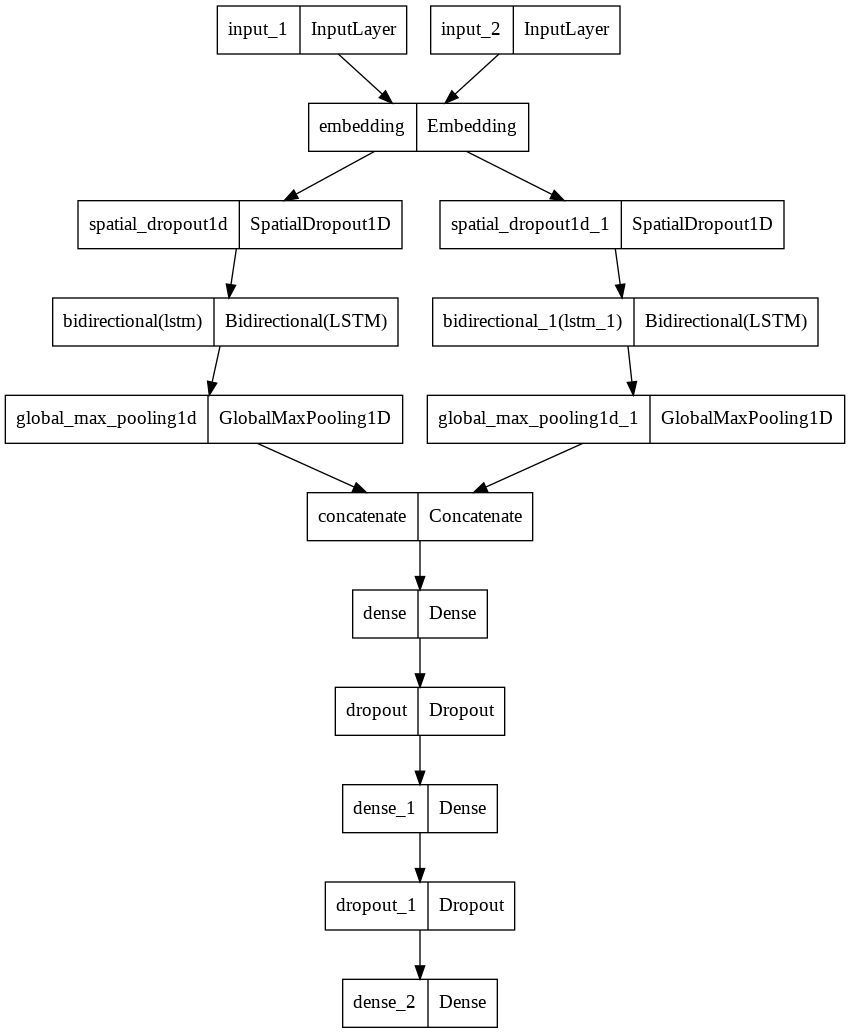

In [46]:
tf.keras.utils.plot_model(model)

In [26]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [27]:
history = model.fit(
    x = [train_long_answers, train_questions], 
    y = train_labels,
    validation_data = (
        [val_long_answers, val_questions], 
        val_labels
    ),
    epochs = EPOCHS,
    callbacks = callbacks,
    class_weight = CLASS_WEIGHTS,
    batch_size = BATCH_SIZE,
    shuffle = True
) 

Epoch 1/30
3006/3006 [==============================] - 310s 100ms/step - loss: 0.3082 - binary_accuracy: 0.8130 - recall: 0.7585 - precision: 0.1846 - val_loss: 0.3217 - val_binary_accuracy: 0.8010 - val_recall: 0.8849 - val_precision: 0.1943 - lr: 0.0010
Epoch 2/30
3006/3006 [==============================] - 299s 99ms/step - loss: 0.2730 - binary_accuracy: 0.8452 - recall: 0.7844 - precision: 0.2214 - val_loss: 0.2785 - val_binary_accuracy: 0.8781 - val_recall: 0.7861 - val_precision: 0.2719 - lr: 0.0010
Epoch 3/30
3006/3006 [==============================] - 299s 99ms/step - loss: 0.2583 - binary_accuracy: 0.8559 - recall: 0.7893 - precision: 0.2358 - val_loss: 0.2888 - val_binary_accuracy: 0.8373 - val_recall: 0.8868 - val_precision: 0.2292 - lr: 0.0010
Epoch 4/30
3006/3006 [==============================] - 299s 100ms/step - loss: 0.2472 - binary_accuracy: 0.8599 - recall: 0.8054 - precision: 0.2438 - val_loss: 0.1843 - val_binary_accuracy: 0.9089 - val_recall: 0.7560 - val_preci

## Model Evauluate

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    23132400    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 100)   0           ['embedding[0][0]']          

Text(0, 0.5, 'loss')

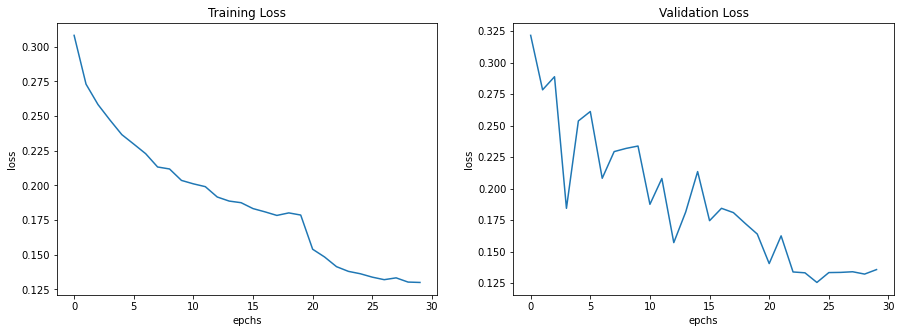

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])
ax[0].set_xlabel("epchs")
ax[0].set_ylabel("loss")

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])
ax[1].set_xlabel("epchs")
ax[1].set_ylabel("loss")

Text(0, 0.5, 'accuracy')

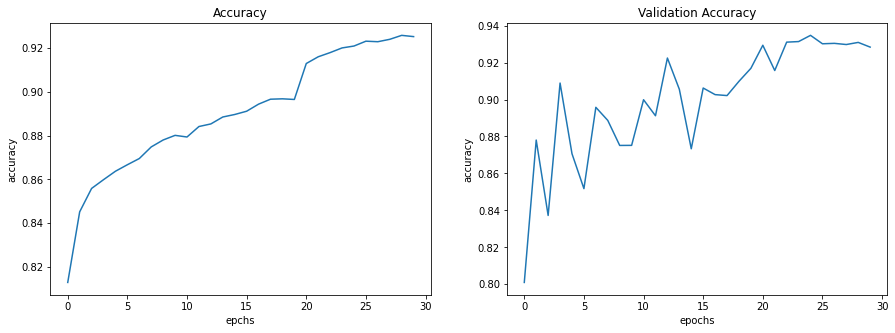

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Accuracy')
ax[0].plot(history.history['binary_accuracy'])
ax[0].set_xlabel("epchs")
ax[0].set_ylabel("accuracy")

ax[1].set_title('Validation Accuracy')
ax[1].plot(history.history['val_binary_accuracy'])
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")

Text(0, 0.5, 'recall')

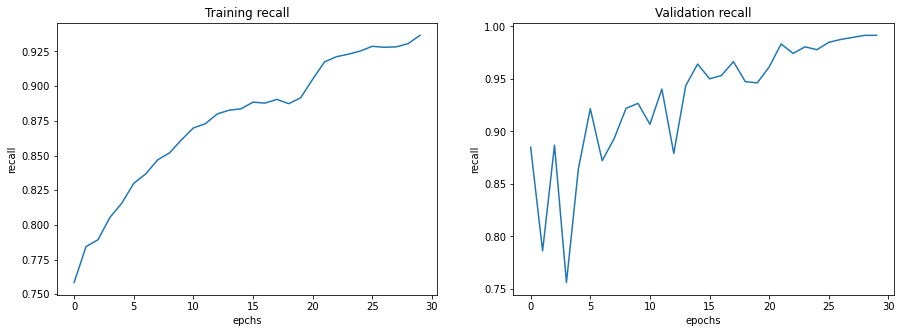

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training recall')
ax[0].plot(history.history['recall'])
ax[0].set_xlabel("epchs")
ax[0].set_ylabel("recall")

ax[1].set_title('Validation recall')
ax[1].plot(history.history['val_recall'])
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("recall")

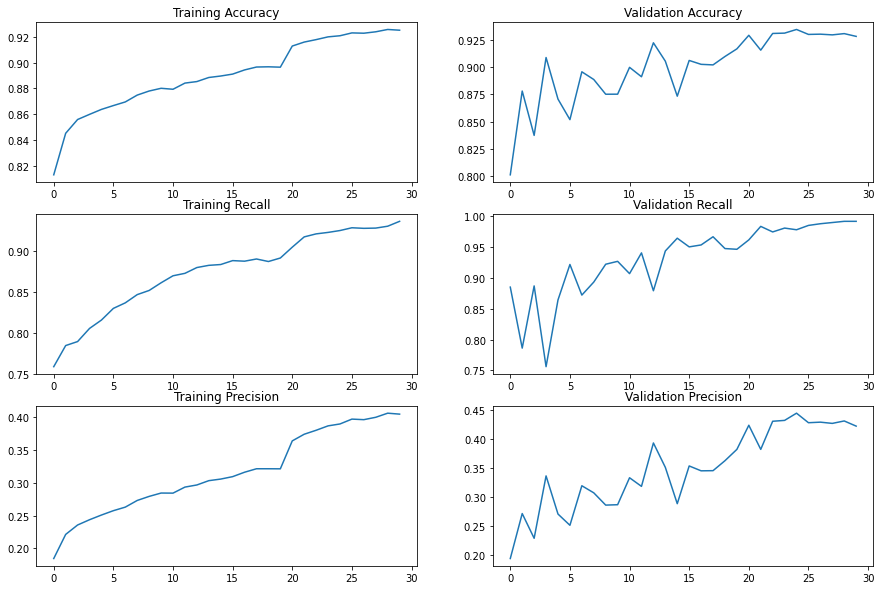

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['binary_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_binary_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['recall'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_recall'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['precision'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_precision'])

I'll also print out the number of epochs the model trained for to see if early stopping took place.

In [30]:
print('Epochs: {0}'.format(
    len(history.history['loss'])
))

Epochs: 30


In [31]:
history_data=pd.DataFrame({"loss":history.history['loss'],"val_loss":history.history['val_loss'],"binary_accuracy":history.history['binary_accuracy'],"val_binary_accuracy":history.history['val_binary_accuracy'],"recall":history.history['recall'],"val_recall":history.history['val_recall'],"precision":history.history['precision'],"val_precision":history.history['val_precision']})

In [32]:
history_data.head()

,loss,val_loss,binary_accuracy,val_binary_accuracy,recall,val_recall,precision,val_precision
0,0.308189,0.321701,0.813005,0.800997,0.758538,0.884856,0.184593,0.194292
1,0.272994,0.278452,0.845188,0.878066,0.784402,0.786105,0.221411,0.271905
2,0.258334,0.288845,0.855871,0.837264,0.789295,0.886807,0.235800,0.229240
3,0.247196,0.184336,0.859863,0.908914,0.805372,0.756050,0.243847,0.336870
4,0.236629,0.253727,0.863715,0.870657,0.815658,0.864169,0.251022,0.271058


In [33]:
history_data.to_csv("history_data.csv")

The final metric I'll use is F1 score. This is a combination of precision and recall and the metric the competition (now closed) used to measure the quality of models. It's thus a good single metric that encompasses the quality of the model.

In [38]:
recall = history.history['recall'][-1]
precision = history.history['precision'][-1]

print('Train F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Train F1 score: 0.5656


In [37]:
recall = history.history['val_recall'][-1]
precision = history.history['val_precision'][-1]

print('Validation F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Validation F1 score: 0.5928


In [43]:
def test_question(question, positive, negative):
    sentences = [question, positive, negative]
    
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict(
        [np.expand_dims(sentences[1], axis=0), np.expand_dims(sentences[0], axis=0)]
    )

    print('Positive: {0:.2f}'.format(predictions[0][0]))

    predictions = model.predict(
        [np.expand_dims(sentences[2], axis=0), np.expand_dims(sentences[0], axis=0)]
    )

    print('Negative: {0:.2f}'.format(predictions[0][0]))

Here's a sample question with two answers from the training dataset. Let's see how the model does with them.

In [44]:
question = 'which is the most common use of opt-in e-mail marketing'

positive = "<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

negative = '<P> Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing was not as effective . In 1978 , Gary Thuerk of Digital Equipment Corporation ( DEC ) sent out the first mass email to approximately 400 potential clients via the Advanced Research Projects Agency Network ( ARPANET ) . This email resulted in $13 million worth of sales in DEC products , and highlighted the potential of marketing through mass emails . However , as email marketing developed as an effective means of direct communication , users began blocking out content from emails with filters and blocking programs . In order to effectively communicate a message through email , marketers had to develop a way of pushing content through to the end user , without being cut out by automatic filters and spam removing software . This resulted in the birth of triggered marketing emails , which are sent to specific users based on their tracked online browsing patterns . </P>'

In [ ]:
test_question(question, positive, negative)

In [ ]:
question = 'how i.met your mother who is the mother'

positive = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

negative = "<P> In `` Bass Player Wanted '' , the Mother picks up a hitchhiking Marshall , carrying his son Marvin , on her way to Farhampton Inn . On their way , it is revealed that the Mother is a bass player in the band , that is scheduled to play at the wedding reception . But the band 's leader , Darren , forced her to quit . The Mother ultimately decides to confront Darren and retake the band . She ends up alone at the bar , and while practicing a speech to give Darren , Darren walks up to her furious the groom 's best man punched him for `` no reason . '' Amused by this , the Mother laughs , and Darren quits the band in anger . </P>"

In [ ]:
test_question(question, positive, negative)